# Proyecto Inteligencia Artificial 

Integrantes del equipo:

Claudia Alejandra Cruz Olivas 16111820

Diego Alexis Mier Rutiaga 16111728

Cruz David Hernández Antunez 15111430 

Daniel Moreno Millán 16111652

Docente: Ing. Samuel Martínez Magdaleno.

## Predictor de Ventas de Consolas de PS4 por medio de Redes Neuronales.

El siguiente proyecto consiste en un algoritmo que utiliza distintas librerías (keras, sklearn, pandas) para predecir las futuras ventas de las consolas PS4 tomando en cuenta las ventas semanales pasadas recabadas en un año. Nuestro datos son una serie temporal, que significa que son un conjunto de muestras tomadas a intervalos de tiempo regulares.
A diferencia de los algoritmos de Regresión Lineal(cuyas variables son independientes),  las series temporales son dependiente del tiempo, suelen tener un tipo de estacionalidad (a veces crecen y otras veces decren) así como un comportamiento a largo y mediano plazo intentando detectar algun patrón entre sus variables.

Para entrar un poco mas en contexto, hay que definir mas a fondo como trabajan las librerías que utilizaremos.
Tensorflow es una plataforma de extremo a extremo que le facilita la creación e implementación de modelos MachineLearning, para que puedas crear tus algoritmos de una manera más eficiente.
Utilizamos la librería de Keras para para que nos sea más fácil describir las capas de la red que creamos.

Comenzando con el código,primero se importan las librerías que utilizaremos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.
C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529

Después, mandamos a llamar nuestros datos asignándole la variable Dataframe, recordemos que con el comando ".head()" se visualizan los primeros 5 Datos.

In [2]:
Dataframe = pd.read_csv('PS4_sales.csv',names=["Unidades vendidas"])
Dataframe.head()

,Unidades vendidas
2019-06-01,200501.0
2019-06-08,233161.0
2019-06-15,227211.0
2019-06-22,215190.0
2019-06-29,220317.0


con el comando .describe () nos proporciona la estadística descriptiva del conjunto de datos, ya sea la media, desviación estándar, mínimos y máximos, etc.


In [3]:
Dataframe.describe()

,Unidades vendidas
count,5.100000e+01
mean,2.697288e+05
std,1.962340e+05
min,1.364550e+05
25%,1.843605e+05
50%,2.119810e+05
75%,2.561665e+05
max,1.382523e+06


A continuación, se verá la fecha mínima y la fecha máxima de los datos capturados en nuestra base de datos. Aproximadamente cubre las ventas que se han tenido a lo largo de un año

In [4]:
print(Dataframe.index.min())
print(Dataframe.index.max())

2019-06-01
2020-05-30


Cargamos la gráfica de las consolas vendidas semanalmente a lo largo del año 

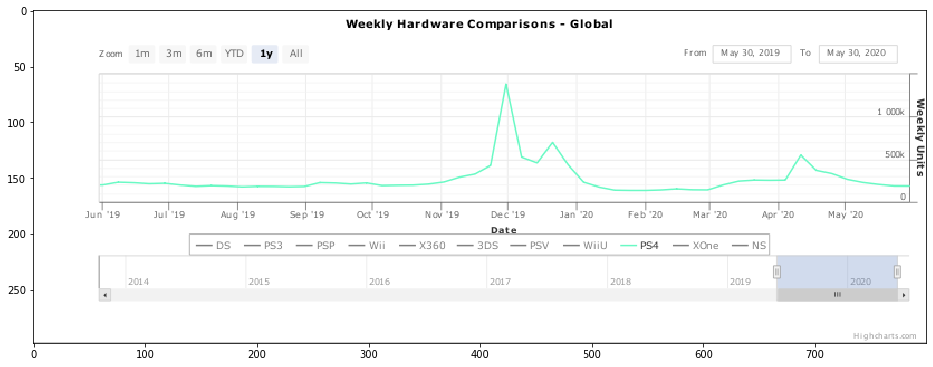

In [5]:
ventas=mpimg.imread('grafica.png')
imgplot=plt.imshow(ventas)
plt.show()

En la gráfica siguiente se muestra con mejor visualización las consolas más vendidas en todo el año, en el mes de nov a dic (gráfica azul) y de diciembre a enero(gráfica naranja).

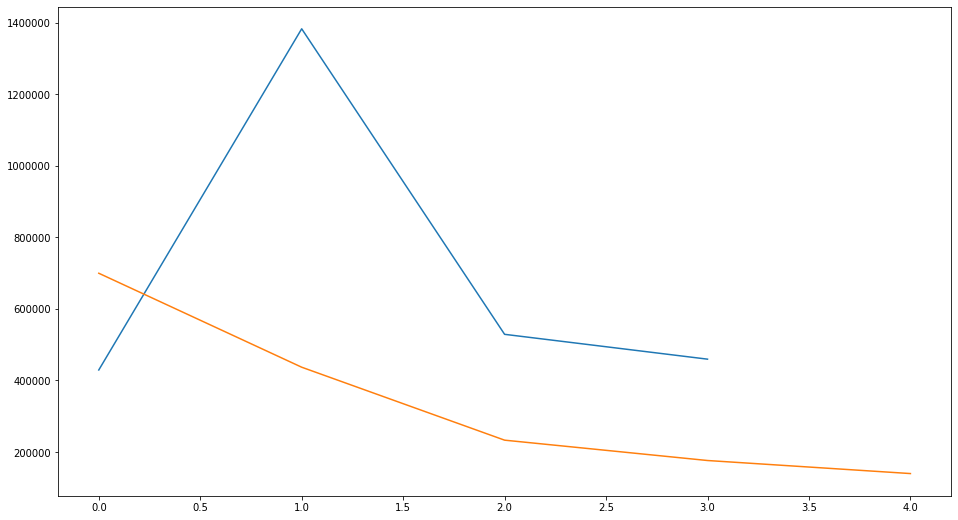

In [6]:
novdic = Dataframe['2019-11-20':'2019-12-20']
plt.plot(novdic.values)
dicene = Dataframe['2019-12-21':'2020-01-20']
plt.plot(dicene.values)

### Serie a Aprendizaje Supervisado

Despues de visualizar los datos y las consolas vendidas, se creará una Red Neuronal que con los datos obtenidos, nos pueda pronosticar cuántas consolas se venderán en el proximo mes.

Para comenzar a trabajar con nuestra red neuronal, primero tenemos que convertir nuestra serie( o datos de entrada) en un problema de tipo supervisado ( Aprendizaje Supervisado) diviendo los datos en varias columnas para poder entrenar nuestra red neuronal. 
Recordemos que el aprendizaje supervisado los datos para el entrenamiento incluyen la solución deseada, llamada «etiquetas» (labels).
Entonces, para poder entrenar nuestra red neuronal con Back propagation debemos tener entradas y salidas.

Lo que se hará a continuación,será tomar las 7 semanas previas para obtener la 8va.
Entonces, de entrada se tienen las 7 columnas que representan las ventas de consolas de las 7 semanas anteriores.
La salida será el valor de las ventas de consolas en la 8va semana. 

Para hacer la transformación de datos (explicada anteriormente) se utilizará una función "series to supervised()" creada por el D.r Jason Brownlee

In [7]:

# Convertir la serie a Aprendizaje Supervisado
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
   #Secuencia de entrada (t-1, t-n)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Pronostico de la secuencia (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # concatenar los datos
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Elimina la fila donde se encuentran los valores Nulos.
    if dropnan:
        agg.dropna(inplace=True)
    return agg


WEEKS=7
# Se carga la base de datos 
values = Dataframe.values
# Se asegura que los datos sean flotantes
values = values.astype('float32')
# nnormalizar los datos
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
# conversión a aprendizaje supervisado
reframed = series_to_supervised(scaled, WEEKS, 1)


reframed.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,-0.897203,-0.844782,-0.854332,-0.873626,-0.865397,-0.898004,-0.922789,-0.909912
16,-0.932886,-0.923429,-0.924662,-0.931159,-0.925673,-0.851729,-0.859096,-0.878777
17,-0.923429,-0.924662,-0.931159,-0.925673,-0.851729,-0.859096,-0.878777,-0.857905
18,-0.924662,-0.931159,-0.925673,-0.851729,-0.859096,-0.878777,-0.857905,-0.908223
19,-0.931159,-0.925673,-0.851729,-0.859096,-0.878777,-0.857905,-0.908223,-0.902959


Con los valores de la tabla anterior, vamos a tomar los datos de entrada aquellos que tienen "(t-7)....(t-1)" y como valor de salida a "(t).

### Creación de la Red Neuronal.

Antes de entrenar nuestra Red Neuronal, es necesario subdividir el conjunto de datos de entrada en un conjunto de entrenamiento y uno más para validar el modelo. Se hará una subdivision de las 27 semanas para el entrenamiento de la red y las 18 semanas restantes son para su validación.

In [8]:
# Dvidir entra datos de entrenamiento y validación.
values = reframed.values
train_weeks = 52 - (18+WEEKS)
train = values[:train_weeks, :]
test = values[train_weeks:, :]
# Dividir entre entradas y salidas
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# Transformar la entrada en un arreglo
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(27, 1, 7) (27,) (10, 1, 7) (10,)


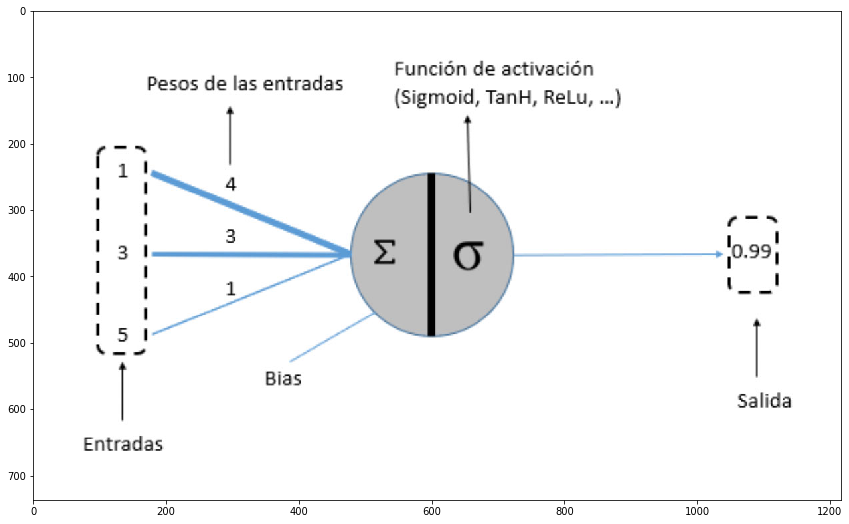

In [9]:
red=mpimg.imread('redes.jpg')
imgplot=plt.imshow(red)
plt.show()

Para nuestra función de activación, se utilizará la tangente hiperbólica ya que estamos manejando numeros de -1 a 1. A continuación se observa la imagen de la tangente hiperbólica.

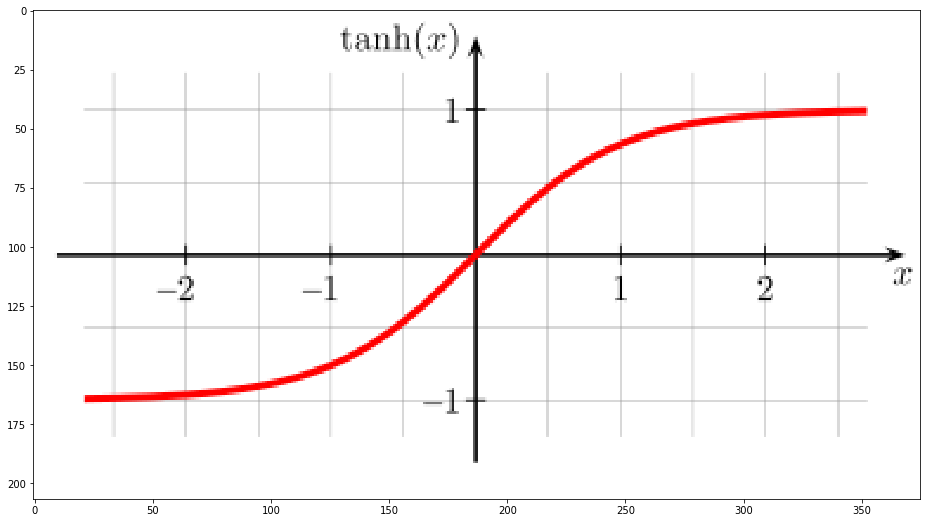

In [10]:
grafica=mpimg.imread('tangente.png')
imgplot=plt.imshow(grafica)
plt.show()

Con ayuda de la librería de Keras se hace la estructura de la Red Neuronal.

In [11]:
#Función para crear la red.
def crear_modeloFF():
    #La función Sequential nos ayuda a obtener caracterízticas e inferencia en el modelo para capacitar la red neuronal
    model = Sequential()
    #Estructura de la red(capas)
    model.add(Dense(WEEKS, input_shape=(1,WEEKS),activation='tanh'))
    #Con la función Flatten nos acomoda los datos
    model.add(Flatten())
    #Los pesos totales se van a la función de activación.
    model.add(Dense(1, activation='tanh'))
    #Compilación de las capas neuronales y optimización de la red.
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    #Se lee lo existente para al final devolver el valor de model con los datos de la red.
    model.summary()
    return model

Después, se entrenará la red con las iteraciones indicadas en el código mandando a llamar la función.

In [12]:
iteraciones=40
#Se manda a llamar la función
model = crear_modeloFF()
#.fit es utilizado para entrenar la red las veces que sean necesarias, el modelo es utilizado para bases de datos pequeños numpy
historial=model.fit(x_train,y_train,epochs=iteraciones,validation_data=(x_val,y_val),batch_size=WEEKS)

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1, 7)              56        
_________________________________________________________________
flatten_1 (Flatten)          (None, 7)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 8         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 27 samples, validate on 10 samples
Epoch 1/40
27/27 [==============================] - 0s 6ms/step - loss: 1.2700 - mse: 1.8818 - val_loss: 1.1981 - val_mse: 1.4886
Epoch 2/40
27/27 [==============================] - 0s 333us/step - loss: 1.2431 - mse: 1.7971

10


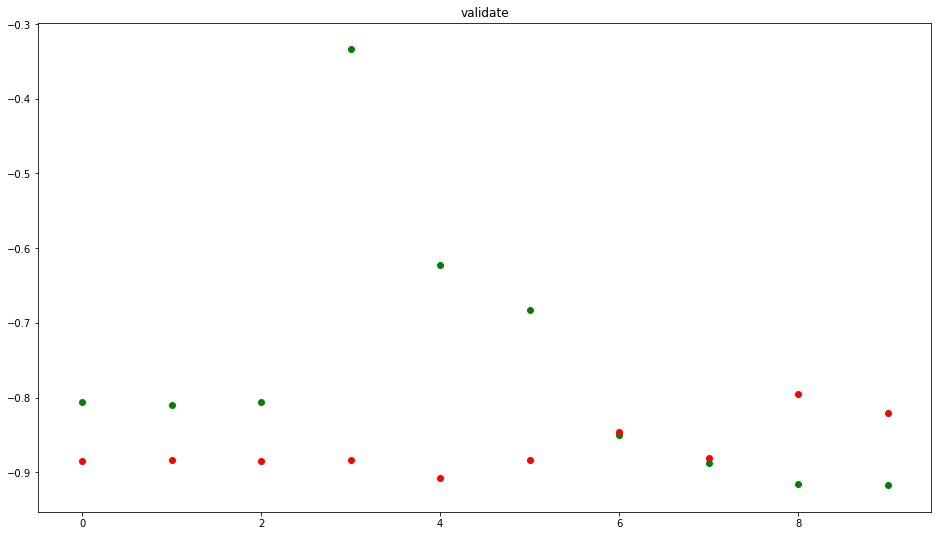

In [13]:
#La función model.predict de keras predice el valor que tomamos como entrada al momento de entrenar y validar nuestros datos.
resultados=model.predict(x_val)
print( len(resultados) )
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(resultados)),resultados,c='r')
plt.title('validate')
plt.show()

Para saber si nuestra red esta aprendiendo, se grafican el error de las iteraciones vs el error final para ver que tan precisos son.

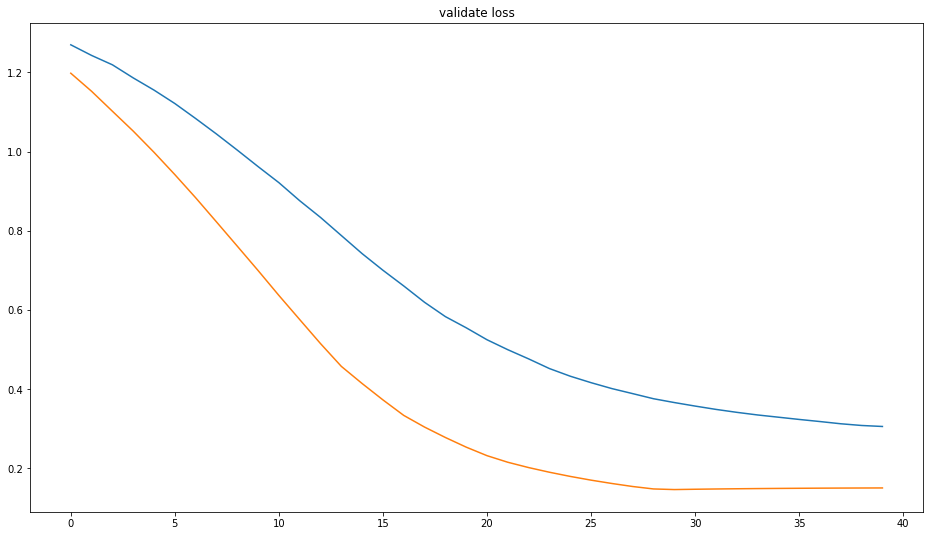

In [14]:
plt.plot(historial.history['loss'])
plt.title('loss')
plt.plot(historial.history['val_loss'])
plt.title('validate loss')
plt.show()

Una vez que se tiene la Red Neuronal entrenada, se hará la predicción de ventas de consolas PS4 para el próximo mes de Junio.

Usaremos los datos recabados del número de consolas vendidas de 14 semanas en lo que va del año

In [15]:
transcurso = Dataframe['2020-02-22':'2020-05-31']
print(transcurso)

            Unidades vendidas
2020-02-22           144366.0
2020-02-29           143008.0
2020-03-07           200896.0
2020-03-14           245611.0
2020-03-21           257531.0
2020-03-28           255150.0
2020-04-04           257183.0
2020-04-11           551388.0
2020-04-18           371529.0
2020-04-25           334080.0
2020-05-09           230140.0
2020-05-16           206575.0
2020-05-23           189185.0
2020-05-30           188122.0


Se comienza con el procesado de datos como se hizo anteriormente por medio de la funcion "Series to supervised" pero esta vez no se incluye la columna de salida.

In [16]:
values = transcurso.values
values = values.astype('float32')
# normalizando las características de las entradas 
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimensión
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, WEEKS, 1)
#Aqui se elimina la última columna de donde daba el valor de salida.
reframed.drop(reframed.columns[[7]], axis=1, inplace=True)
reframed.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
7,-0.993349,-1.000000,-0.716499,-0.497512,-0.439135,-0.450796,-0.440839
8,-1.000000,-0.716499,-0.497512,-0.439135,-0.450796,-0.440839,1.000000
9,-0.716499,-0.497512,-0.439135,-0.450796,-0.440839,1.000000,0.119159
10,-0.497512,-0.439135,-0.450796,-0.440839,1.000000,0.119159,-0.064244
11,-0.439135,-0.450796,-0.440839,1.000000,0.119159,-0.064244,-0.573280


Se analizan los valores y se toma la última columna de información, ya que esa corresponde a la última semana de muestras antes de la predicción. Se transforma con el .reshape para que la red la pueda analizar. 

In [17]:
values = reframed.values
x_test = values[6:,:]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test)

[[[-0.4408394   1.          0.11915863 -0.06424403 -0.57327974
   -0.68868697 -0.7738527 ]]]


Luego, se crea una función que nos va a ir rellenando el desplazamiento que se hace por cada predicción.Esto es como un for que va llenando los espacios cada que estés creando una iteración del día anterior.

In [18]:
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

El for que se utiliza a continuación es utilizado para las predicciones de las próximas 4 semanas.

In [19]:
results=[]
#El 4 es por las 4 semanas de predicción.
for i in range(4):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

[[[-0.4408394   1.          0.11915863 -0.06424403 -0.57327974
   -0.68868697 -0.7738527 ]]]
[[[ 1.          0.11915863 -0.06424403 -0.57327974 -0.68868697
   -0.7738527  -0.52300614]]]
[[[ 0.11915863 -0.06424403 -0.57327974 -0.68868697 -0.7738527
   -0.52300614  0.35111275]]]
[[[-0.06424403 -0.57327974 -0.68868697 -0.7738527  -0.52300614
    0.35111275 -0.565112  ]]]


como las predicciones están en el dominio del -1 al 1, nosotros queremos los datos en una escala real, así que vamos a tranformar otra vez los datos con la función de scaler.inverse_transform.

In [20]:
resultados = [x for x in results]    
invertirv = scaler.inverse_transform(resultados)
print(invertirv)

[[240405.36492677]
 [418891.70776531]
 [231807.77040929]
 [230134.30289758]]


Una vez que tenemos los datos, los vamos a graficar para poder visualizar las ventas.

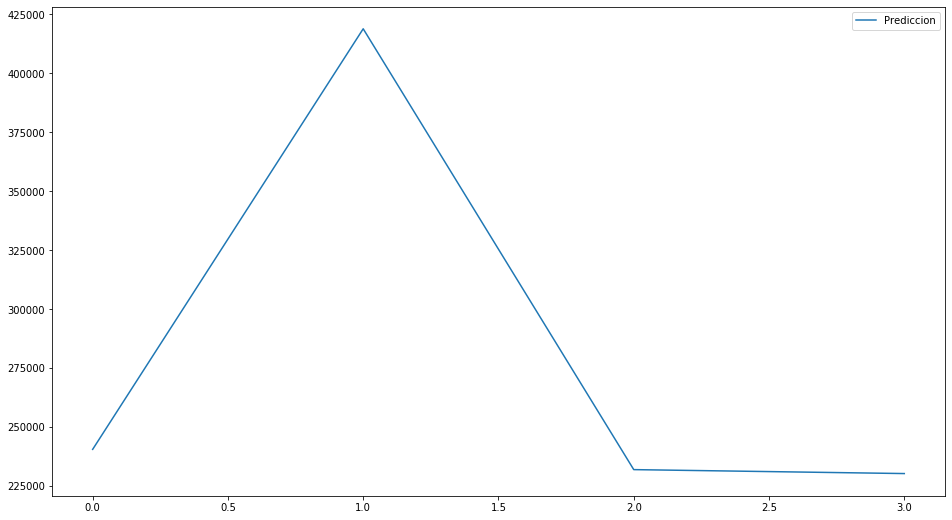

In [21]:
PrediccionSemanas = pd.DataFrame(invertirv)
PrediccionSemanas.columns = ['Prediccion']
PrediccionSemanas.plot()